# Notebook for visualization of results

In [1]:
from experiments.experiment import *
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np

results = Experiment.load_results()

Insert number of runs per experiment below and the number of years each run was executed for.

In [2]:
n_runs = 20
n_years = 50

Re-indexing the dataframe according to the replications and duration of runs.

In [3]:
x_time = np.arange(0, n_runs*n_years)
for i in range(len(x_time)):
    x_time[i] = x_time[i] % n_years

for experiment, runs in results.items():

    runs.index = x_time

Splitting the dataframes for plotting each run. Also, there seems to be one outlier in price of virgin plastics. We will delete this outlier from the general dataset and plot it separately.

In [4]:
separated_results = {}
outlier_price_plastics = {}

for experiment, runs in results.items():
    separated_results[experiment] = []
    outlier_price_plastics[experiment] = []
    for run in range(n_runs):
        run_df = runs.iloc[:n_years, :]
        runs = runs.iloc[n_years+1:, :]

        if run_df['price virgin'].iloc[-1] > 20000.0:
            outlier_price_plastics[experiment].append(run_df)

        else:
            separated_results[experiment].append(run_df)

Generating the dataframe with experimental conditions to find the scenarios which correspond to the same lever combinations.

In [5]:
class Experiment:
    """
    The Experiment class wraps all features that relate to running an experiment and data collection.
    """

    def __init__(self, uncertainty_values=None, lever_values=None):
        #print('Setting up the experiment...\n')
        self.start_time = time.time()

        # Uncertainties
        if uncertainty_values is None:
            self.uncertainty_values = {
                'X1': [1.0, 1.001, 1.01],  # Annual increasing oil price
                'X2': [0.0, 0.001, 0.01],  # Annual probability for a global oil price shock
                'X3': [1.0, 1.001, 1.01],  # Annual increasing recycling efficiency
            }
        else:
            self.uncertainty_values = uncertainty_values

        # Levers
        if lever_values is None:
            self.lever_values = {
                'L1': [0.0, 0.2],  # minimum requirement for reused parts
                'L2': [0.0, 0.2],  # minimum requirement for high-quality recyclate
                'L3': [1.0, 1.2],  # better solvable cohesives
                'L4': [1.0, 1.2],  # externality for virgin plastic
                'L5': [0.0, 0.4],  # minimum requirement for recyclate
            }
        else:
            self.lever_values = lever_values

        self.experimental_conditions = self.prepare_experimental_conditions()

    def prepare_experimental_conditions(self):
        """
        Prepare experimental conditions by creating combinations of all uncertainty and lever values.
        :return:
            experimental_conditions: Dataframe (with column names being X1, ..., X3, L1, ..., L5
        """
        dictionary = {**self.uncertainty_values, **self.lever_values}
        columns = ['X1', 'X2', 'X3', 'L1', 'L2', 'L3', 'L4', 'L5']

        all_values = [dictionary[x] for x in columns]
        rows = list(itertools.product(*all_values))

        experimental_conditions = pd.DataFrame(data=rows, columns=columns)
        return experimental_conditions

In [6]:
experiment_test = Experiment()
experimental_conditions = experiment_test.prepare_experimental_conditions()

In [7]:
experimental_conditions.head()

,X1,X2,X3,L1,L2,L3,L4,L5
0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0
1,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.4
2,1.0,0.0,1.0,0.0,0.0,1.0,1.2,0.0
3,1.0,0.0,1.0,0.0,0.0,1.0,1.2,0.4
4,1.0,0.0,1.0,0.0,0.0,1.2,1.0,0.0


In [8]:
levers_df = experimental_conditions.iloc[:, 3:8]
print(len(levers_df))

864


Retrieving unique lever combinations. This allows us to create subplots for each lever combination to be able to see the influences of policies.

In [9]:
unique_levers = levers_df.drop_duplicates()
unique_levers

,L1,L2,L3,L4,L5
0,0.0,0.0,1.0,1.0,0.0
1,0.0,0.0,1.0,1.0,0.4
2,0.0,0.0,1.0,1.2,0.0
3,0.0,0.0,1.0,1.2,0.4
4,0.0,0.0,1.2,1.0,0.0
5,0.0,0.0,1.2,1.0,0.4
6,0.0,0.0,1.2,1.2,0.0
7,0.0,0.0,1.2,1.2,0.4
8,0.0,0.2,1.0,1.0,0.0
9,0.0,0.2,1.0,1.0,0.4


Making a dictionary with unique lever combinations and corresponding scenarios. This way we can plot scenarios with the same lever combinations all in one plot.

In [10]:
same_levers = {}

for i in range(len(unique_levers)):
    lever_combination_unique = unique_levers.iloc[i]
    same_levers[i] = []

    for j in range(len(levers_df)):
        lever_combination = levers_df.iloc[j]

        if lever_combination_unique.equals(other=lever_combination):
            same_levers[i].append(j)

For generating clear subplots, now we will create figure descriptions about which levers are on and off.

In [11]:
lever_descriptions = []

for index, row in unique_levers.iterrows():

    levers_on = []
    for column in unique_levers:

        if unique_levers.loc[index, column] != 1.0:

            if unique_levers.loc[index, column] != 0.0:

                levers_on.append(column)

    lever_description = ''
    for idx, lever in enumerate(levers_on):
        lever_description += lever + ', '

    if levers_on:
        lever_description += 'ON'

    else:
        lever_description = 'All OFF'

    lever_descriptions.append(lever_description)

In [12]:
unique_levers['Lever information'] = lever_descriptions
unique_levers.head()

C:\Users\rpvdp\AppData\Local\Temp/ipykernel_20144/2117899303.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_levers['Lever information'] = lever_descriptions


,L1,L2,L3,L4,L5,Lever information
0,0.0,0.0,1.0,1.0,0.0,All OFF
1,0.0,0.0,1.0,1.0,0.4,"L5, ON"
2,0.0,0.0,1.0,1.2,0.0,"L4, ON"
3,0.0,0.0,1.0,1.2,0.4,"L4, L5, ON"
4,0.0,0.0,1.2,1.0,0.0,"L3, ON"


Retrieving column names to be able to make plots for every separate factor:

In [13]:
for experiment, runs in results.items():
    column_names =  list(runs.columns)[1:]
    print(column_names)
    break

['amount virgin', 'amount recyclate high', 'amount recyclate low', 'amount reused parts', 'amount standard parts', 'cars in garage', 'amount leakage', 'price virgin', 'price recyclate']


Making a dictionary with corresponding units for axis labels.

In [14]:
unit_list = (['Kilogram'] * 3) + (['N'] * 3) + ['Kilogram'] + (['Euro/kilogram'] * 2)

In [15]:
unit_dict = {column_names[i]: unit_list[i] for i in range(len(column_names))}

First visualizing the results of the outlier.

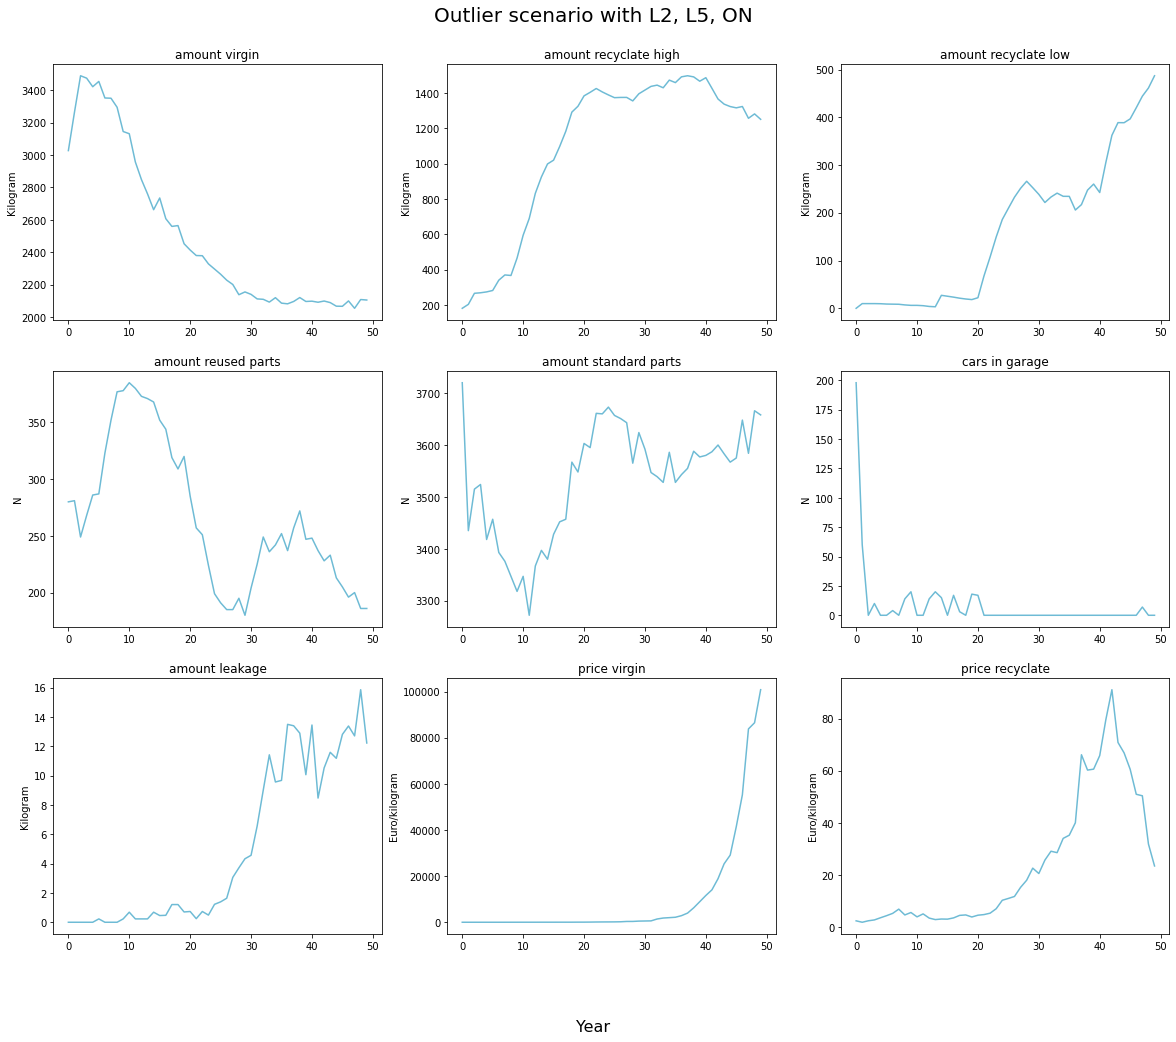

In [16]:
for experiment, run in outlier_price_plastics.items():
    # If there is an outlier
    if run:

        # Then we determine to which lever combination the experiment belongs
        for lever_comb, experiments in same_levers.items():
            # Check whether the outlier experiment is in the list with experiments belonging to the lever combination.
            if experiment in experiments:
                LCB = unique_levers.loc[lever_comb, 'Lever information']

        run_data = run[0]

        N_x = 3
        N_y = 3

        fig, axs = plt.subplots(N_x, N_y, figsize=(20,16))
        fig.suptitle('Outlier scenario with ' + LCB, y=0.93, fontsize=20)
        fig.text(0.5, 0.04, 'Year', ha='center', fontsize=16)

        plot_counter = 0

        for row in range(N_x):

            for column in range(N_y):
                column_name = column_names[plot_counter]
                axs[row, column].plot(run_data.index, run_data[column_name], color='#6ebbd5')
                axs[row, column].title.set_text(column_name)
                axs[row, column].set_ylabel(unit_dict[column_name])

                plot_counter += 1

        fig.savefig('outputimages/outlier.png')

Visualizing results. We will iterate over each separate variable, and then create for each lever combination a subplot containing N replications of N scenarios.

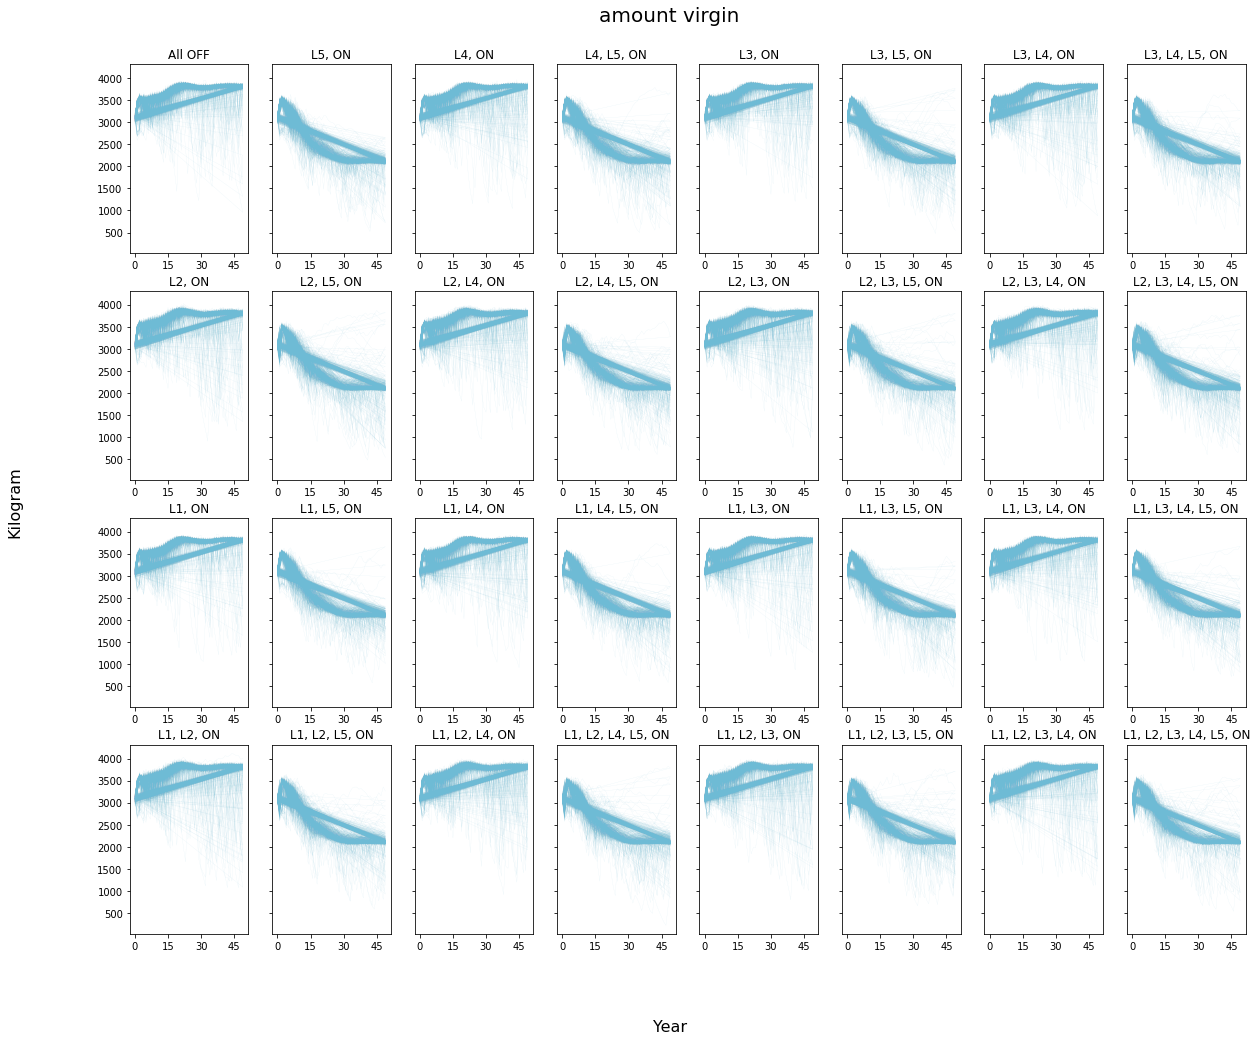

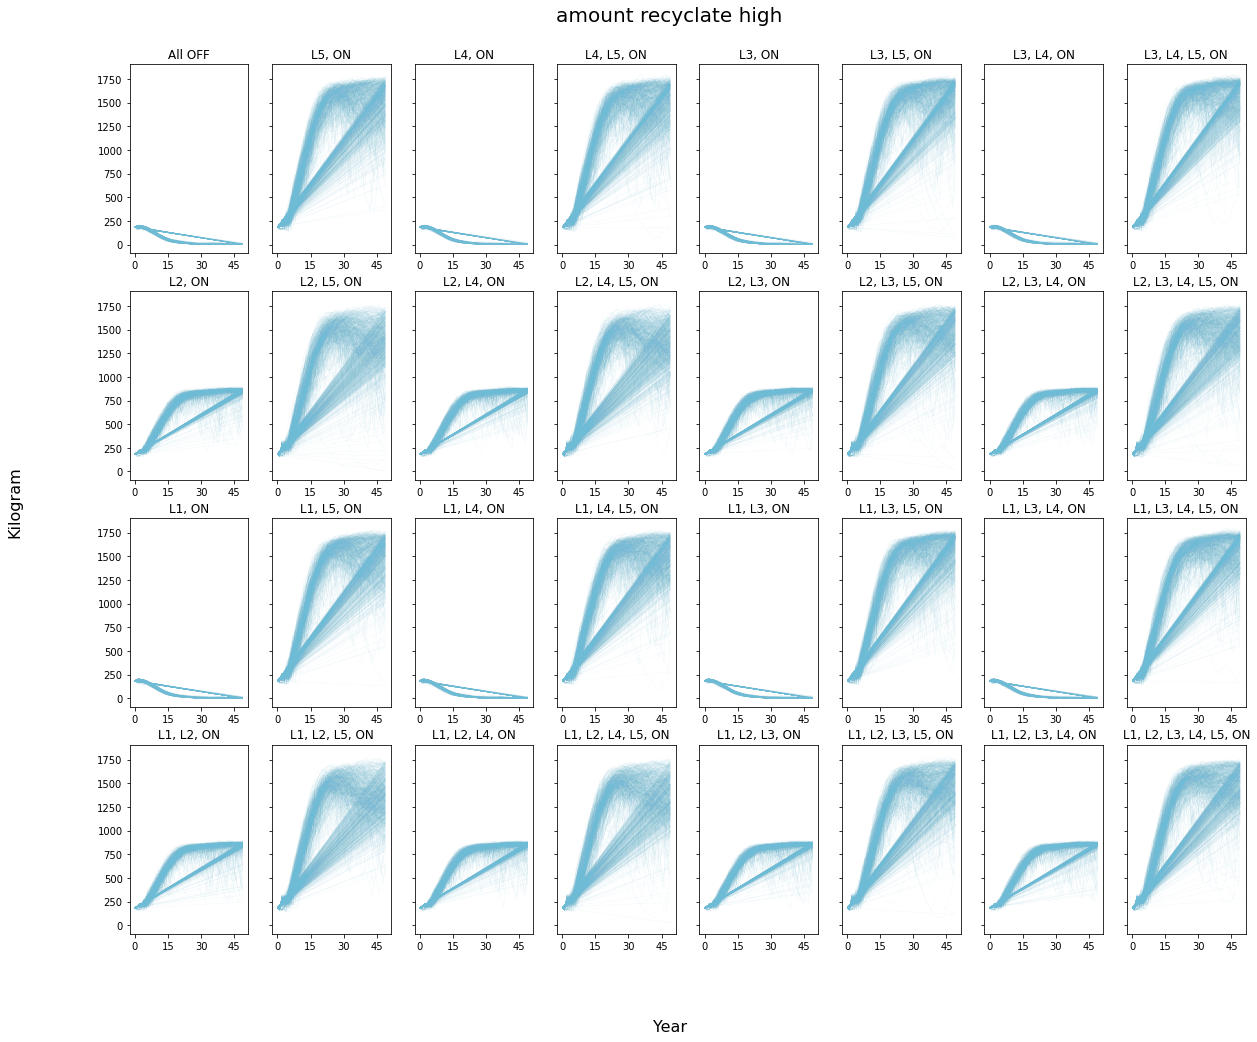

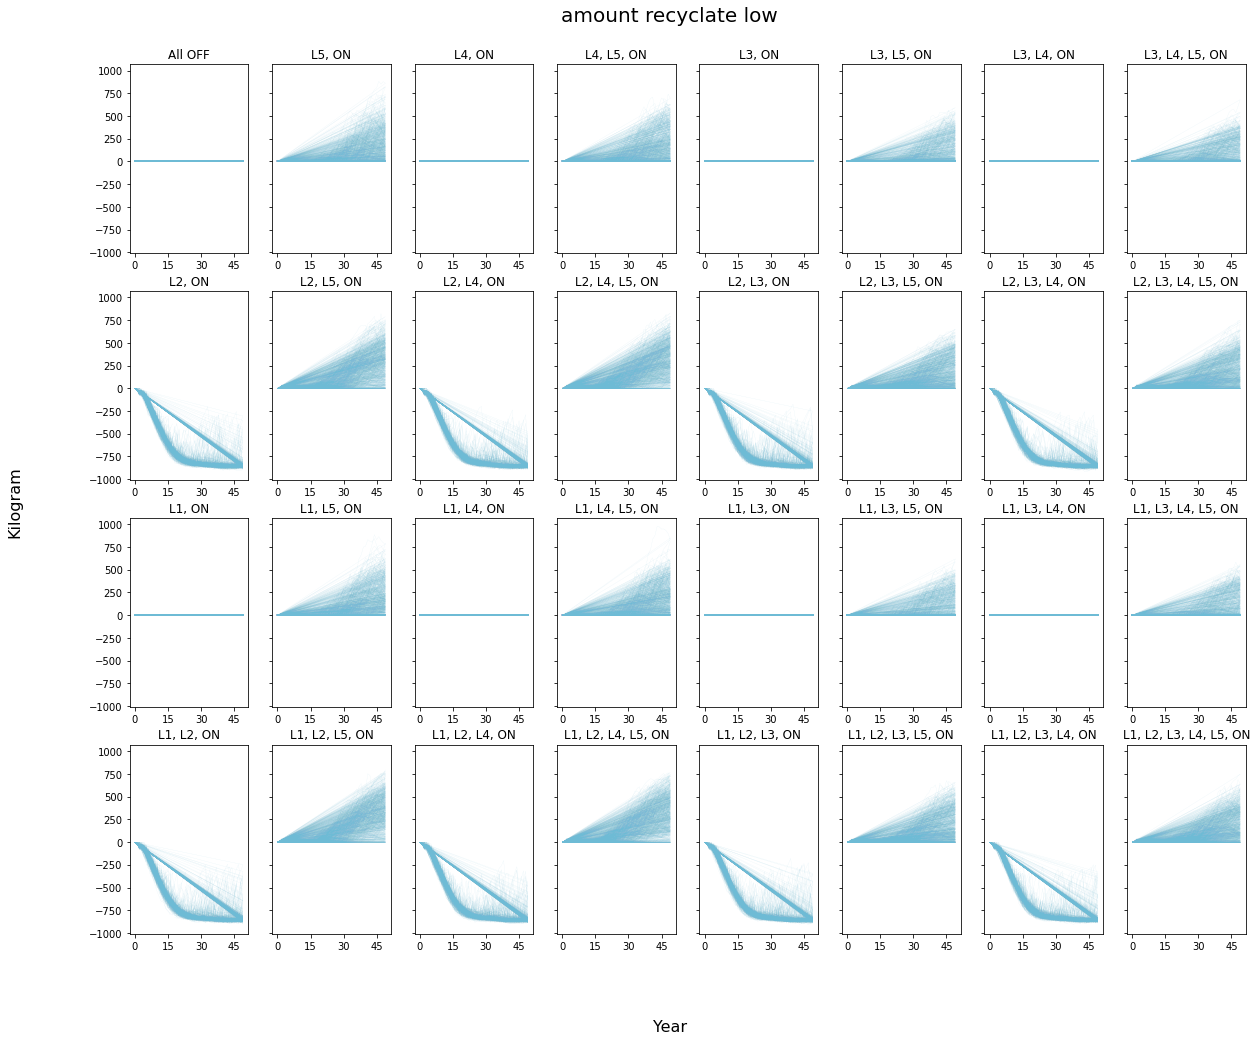

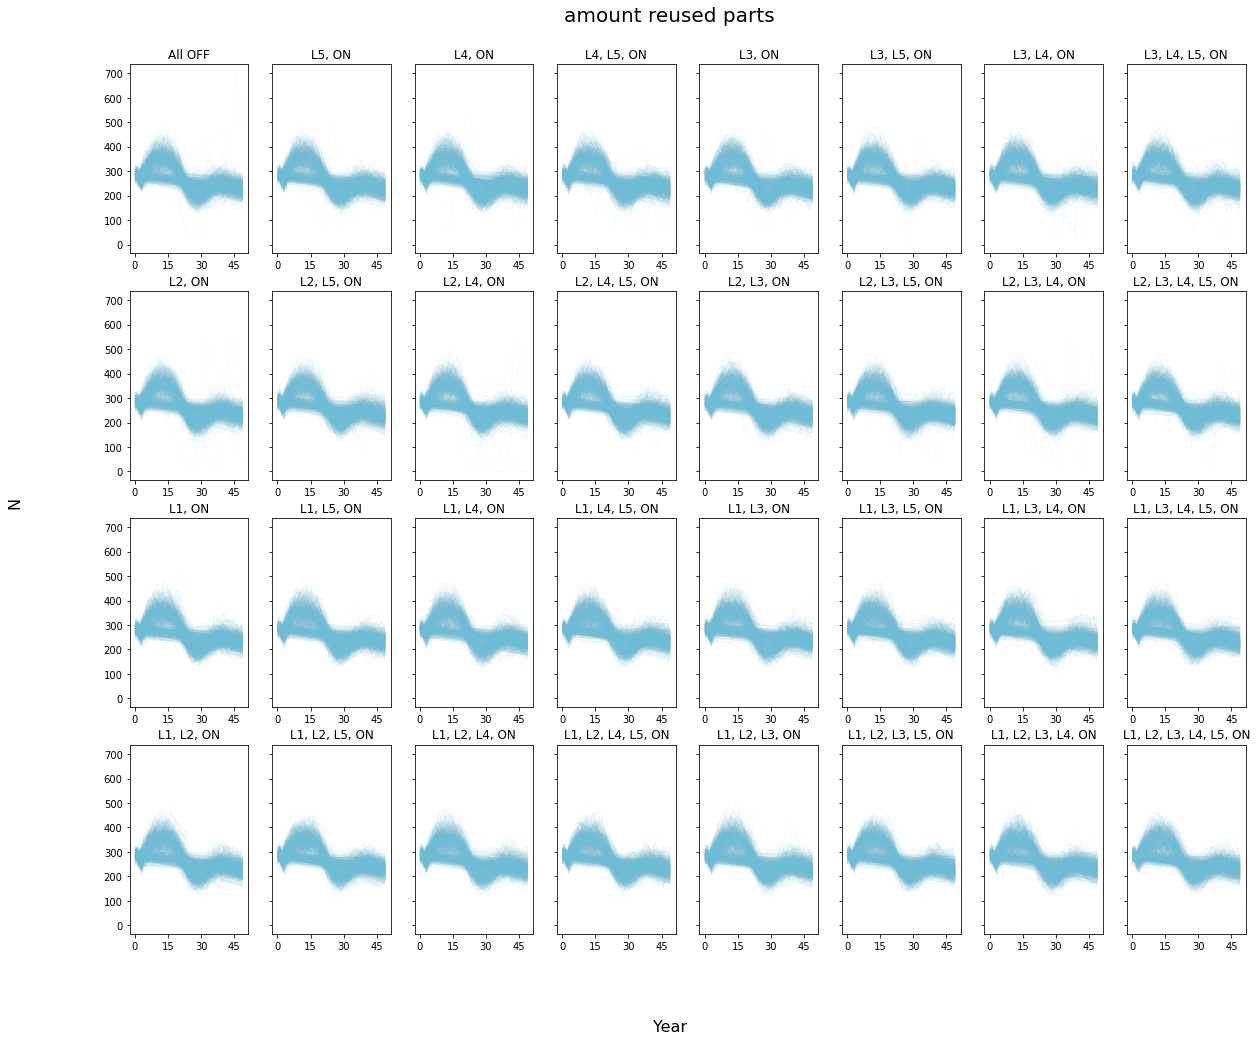

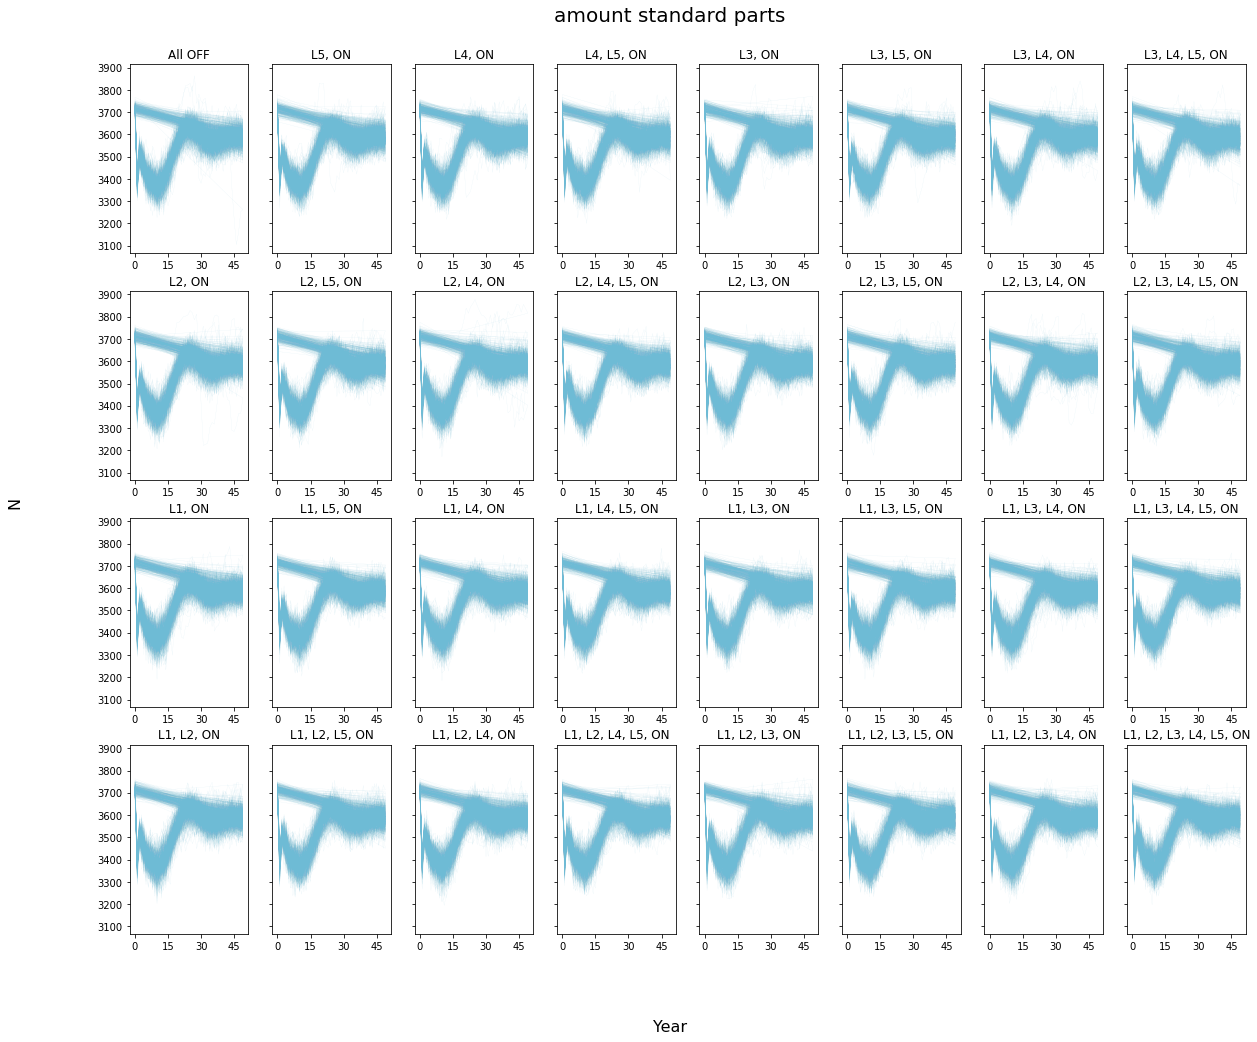

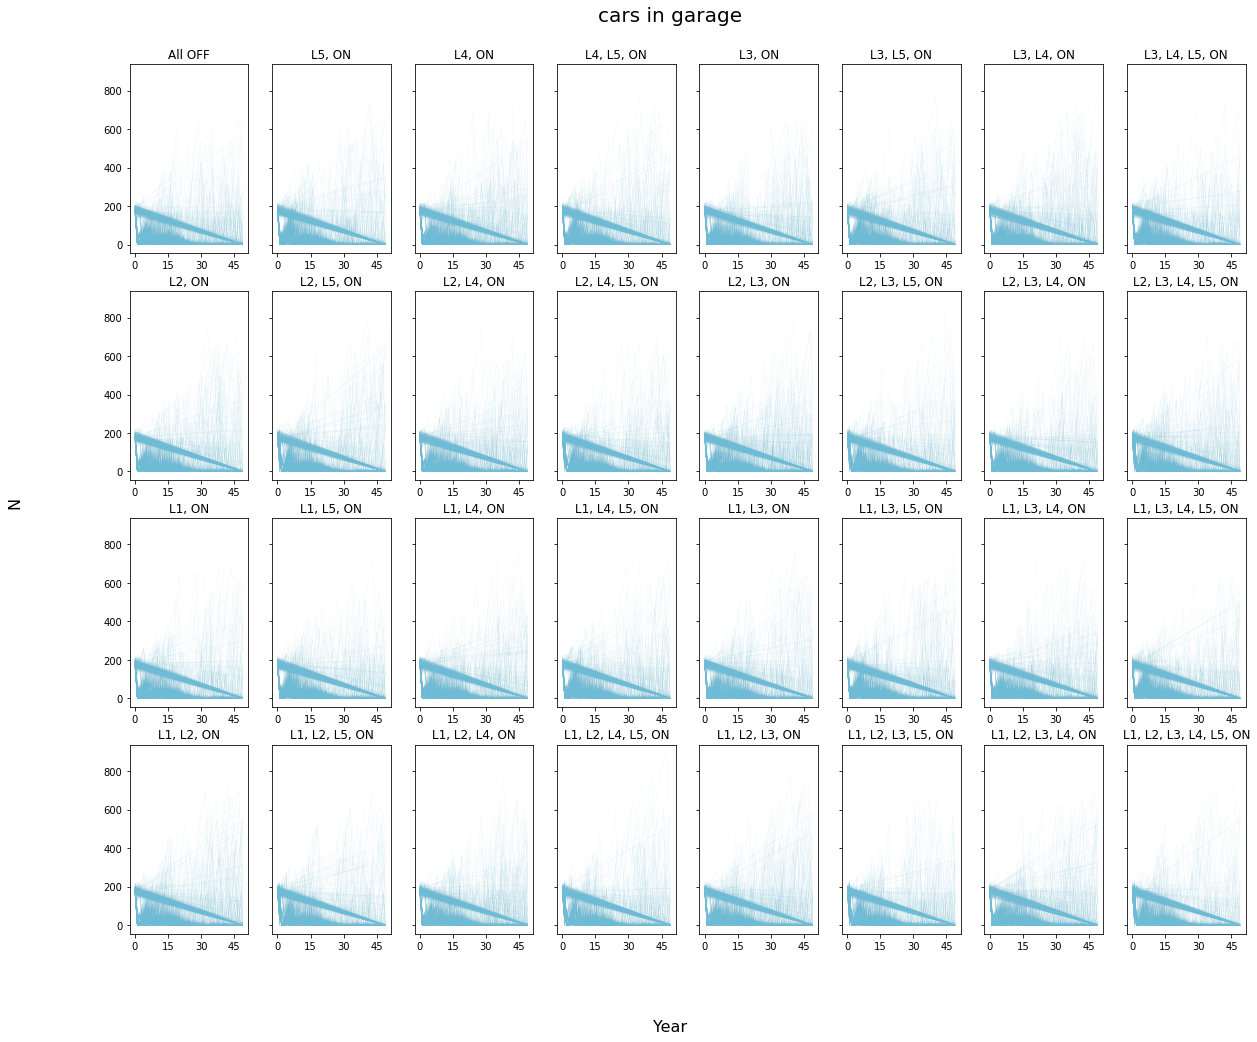

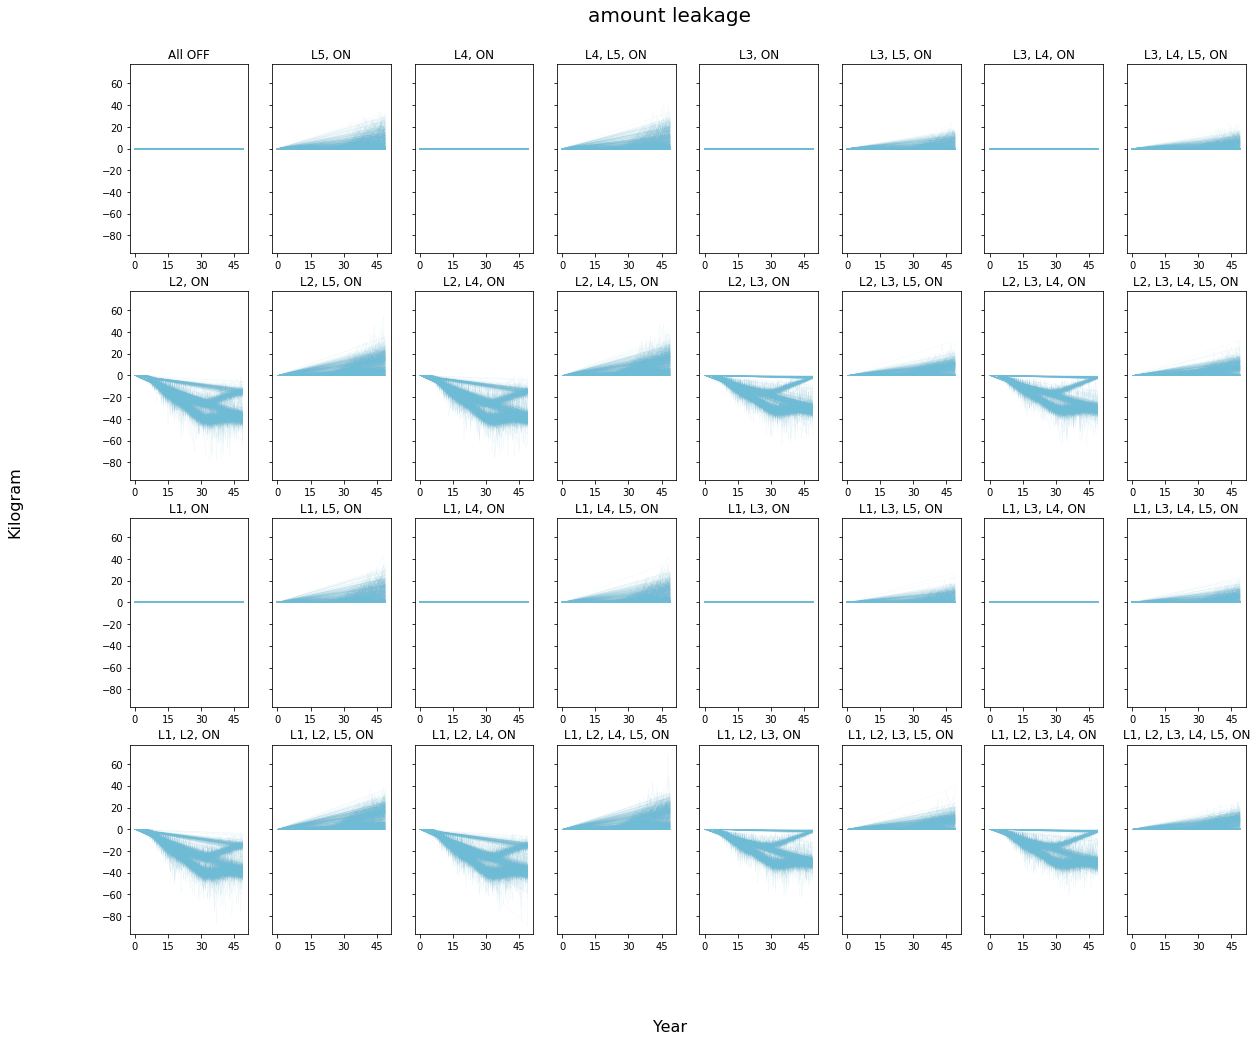

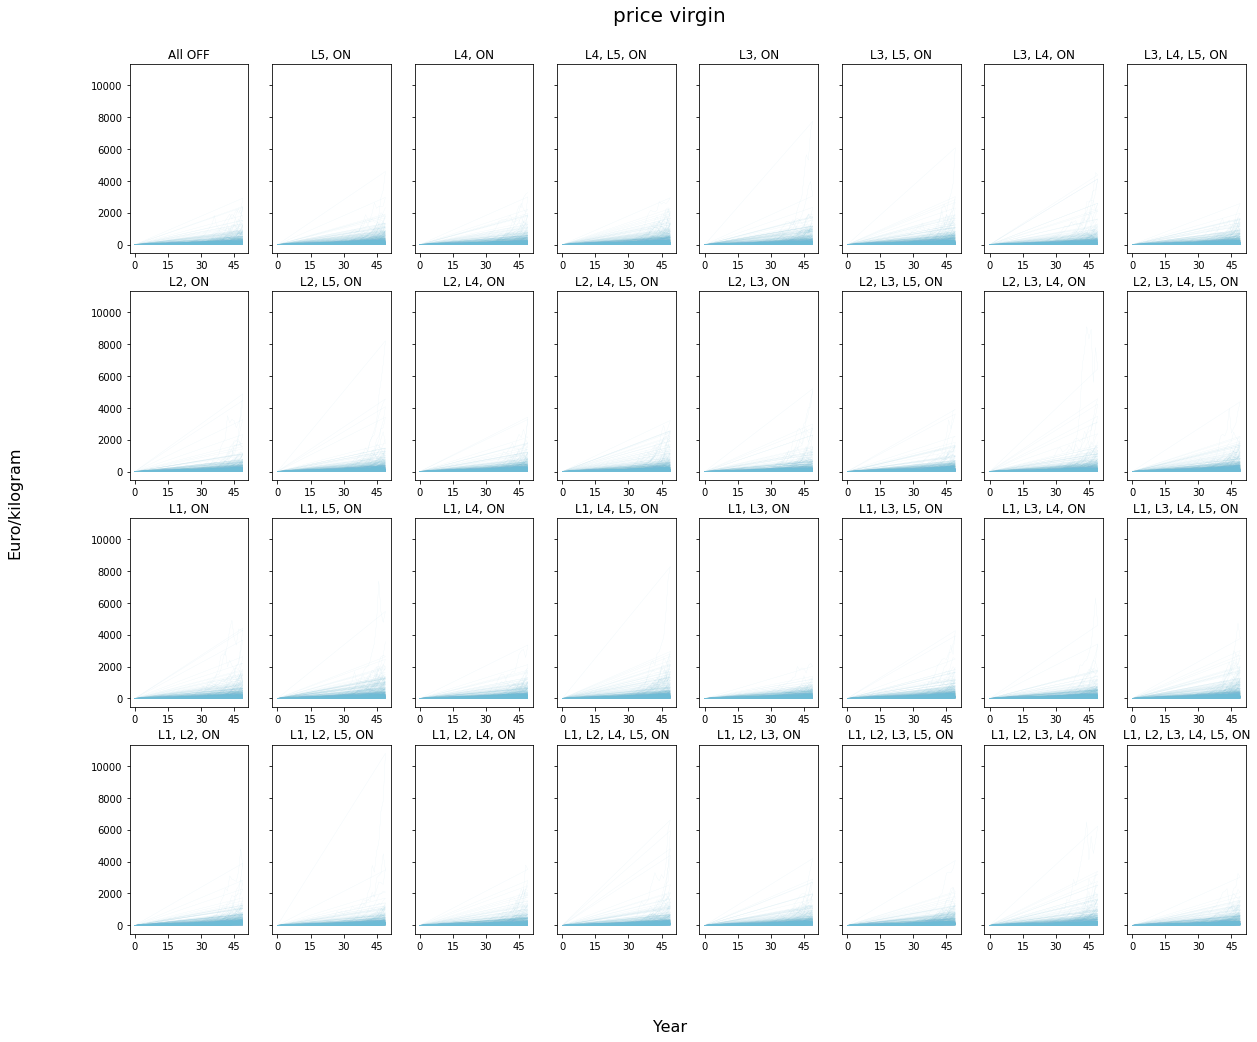

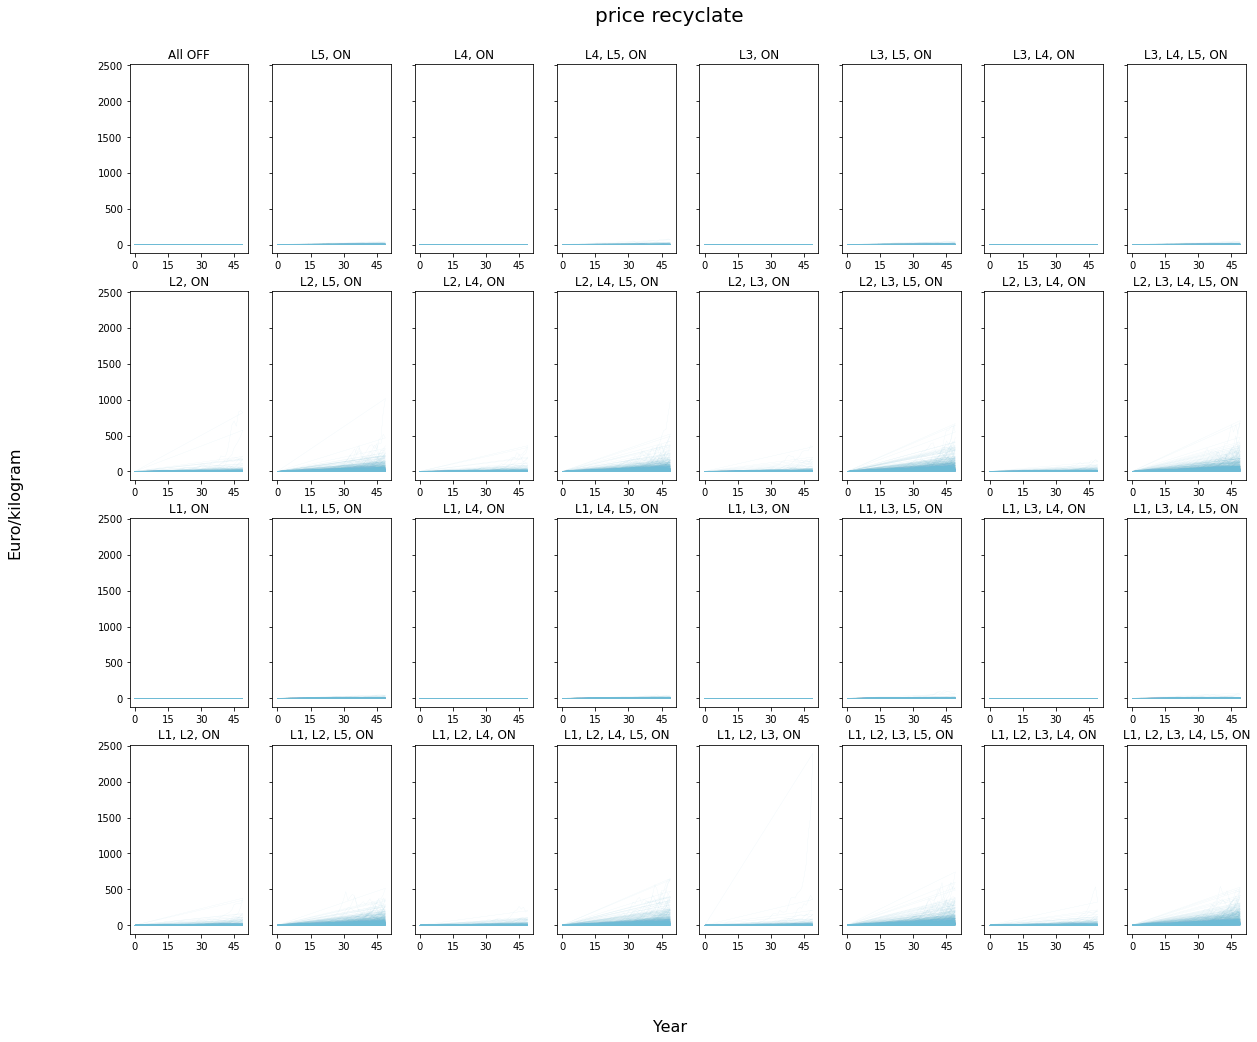

In [17]:
rows = 4
columns = 8

for column_name, unit in unit_dict.items():

    fig, axs = plt.subplots(rows, columns, sharey='all', figsize=(20, 16))
    fig.suptitle(column_name, fontsize=20, y=0.93)
    fig.text(0.5, 0.04, 'Year', ha='center', fontsize=16)
    fig.text(0.04, 0.5, unit_dict[column_name], va='center', rotation='vertical', fontsize=16)
    # First iterate over the columns

    lever_combination_number = 0

    for row_nr in range(rows):
        # Then iterate over the rows
        for column_nr in range(columns):

            # Then see which experiments correspond to this lever combination and plot the N replications of each experiment in the graph
            corresponding_experiments = same_levers[lever_combination_number] # List of experiments

            for experiment_nr in corresponding_experiments:

                experiment_runs = separated_results[experiment_nr]
                # And now plot a line of each run in the experiment
                for run in experiment_runs:

                    axs[row_nr, column_nr].plot(run.index, run[column_name], color='#6ebbd5', linewidth=0.2, alpha=0.2)
                    axs[row_nr, column_nr].title.set_text(unique_levers.loc[lever_combination_number, 'Lever information'])
                    axs[row_nr, column_nr].xaxis.set_major_locator(MaxNLocator(5))

            lever_combination_number += 1

    figure_name = column_name.replace(" ", "_") + '.png'
    fig.savefig('outputimages/' + figure_name)